# Solving the diffusion equation in r (under no-z approximation) 

## Solving for Br and B_Φ

First, will explore the evolution of the magnetic field magnitude and of the exponential decay rate. 

In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from scipy.special import iv,kve,kv #provides module to compute modified bessel function of 1st kind
import numpy as np

In [2]:
def boundary_conditions1():
    Br[0,:] = 0
    Br[Nr,:] = 0
    Br[:,Nt] = 0
    Br[:,0] = 0

In [3]:
# Implement periodic boundary conditions
def boundary_conditions2(B):
    for t in range(0, Nt):
        B[:, t] = np.roll(B[:, t-1], -1, axis=0)
        B[0, t] = B[-1, t]
        B[-1, t] = B[0, t]

In [4]:
#constants
eta_t = 0.5 # η_T estimated as η_t because η is microscopic
h=1 #length scale of galaxy

In [5]:
#GRID PARAMETERS

# Radial grid
R_max = 15 # Maximum radial distance(in kpc)
Nr = 200  # Increased number of grid points in radial direction
dr = R_max / Nr

# Time parameters
T = 5 # Increased total time
Nt = 500 #Total time steps
dt = T / Nt

In [6]:
#6th order finite differencing method
def FDM4(r,Br_val):
    dBrdr = (-1*(Br[i-3,j]) + 9*(Br[i-2,j]) + 45*(Br[i+1,j]) - 9*(Br[i+2,j]) + Br[i+3,j])/(60*dt)
    d2Brdr2 = (2*(Br[i-3,j]) - 27*(Br[i-2,j]) + 270*(Br[i-1,j]) - 490*(Br[i,j]) + 270*(Br[i+1,j]) - 27*(Br[i+2,j]) + 2*(Br[i+3,j]))/(180*dt*dt)
    
    dBrdt = d2Brdr2 - (np.pi)**2*Br_val/(4*h*h) + dBrdr/r - Br_val/(r**2)

    return dBrdt

In [7]:
#Using numpy's gradient function which itself uses a central differencing method
def FDM(R,Bi):
    return np.gradient((1/R)*np.gradient(R*Bi, dr), dr) - ((np.pi)**2)*Bi/(4*h**2)

In [8]:
def RK4(R,Bi):
    k1 = dt * eta_t * FDM(R,Bi)
    k2 = dt * eta_t * FDM(R + 0.5*k1,Bi + 0.5 * k1)
    k3 = dt * eta_t * FDM(R + 0.5*k2,Bi + 0.5 * k2)
    k4 = dt * eta_t * FDM(R + k3,Bi + k3)
    return Bi + (k1 + 2 * k2 + 2 * k3 + k4) / 6

### Using sinusoidal waves as seed fields

In [9]:
# Initializing radial component of Br using different seed fields
R = np.linspace(0.5, R_max, Nr)
Br = np.sin((2* np.pi * R)/R_max)
#Br = np.exp(-R/R_max)
#Br = np.tanh(R/R_max)
#shape = np.shape(R)
#Br = np.random.randint(1,5,*shape)

#Initialising the B_phi field
B_phi = np.cos((2 * np.pi * R)/R_max)
#B_phi = np.exp(R/R_max)
#B_phi = np.tanh(-R/R_max)
#B_phi = np.random.randint(1,5,*shape)

In [10]:
# EVOLUTION OF Br
# Store the evolution of magnetic field at different radial positions
Br_evolution = np.zeros((Nt + 1, Nr))

#boundary_conditions2(Br_evolution)
# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    Br_evolution[t, :] = np.copy(Br)
    Br = RK4(R,Br)
    
#EVOLUTION OF B_phi
    
# Store the evolution of magnetic field at different radial positions
B_phi_evolution = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    B_phi_evolution[t, :] = np.copy(B_phi)
    B_phi = RK4(R,B_phi)   

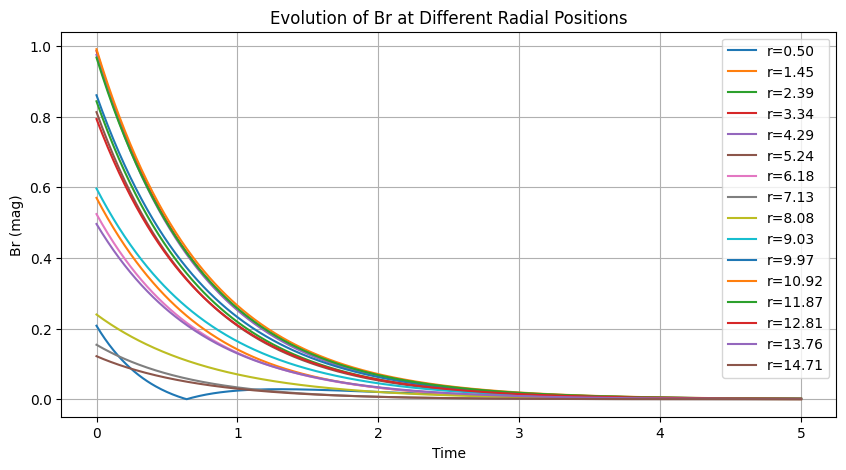

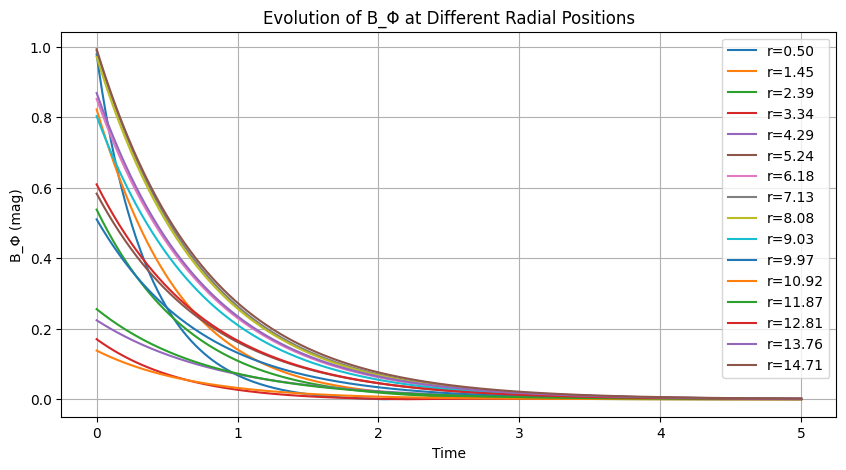

In [11]:
# Plot the evolution of magnetic field at different radial positions over time
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(Br_evolution[:, ::Nr//15]))
plt.xlabel('Time')
plt.ylabel('Br (mag)')
plt.title('Evolution of Br at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(B_phi_evolution[:, ::Nr//15]),label="Evolution curve for B_phi")

plt.xlabel('Time')
plt.ylabel('B_Φ (mag)')
plt.title('Evolution of B_Φ at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

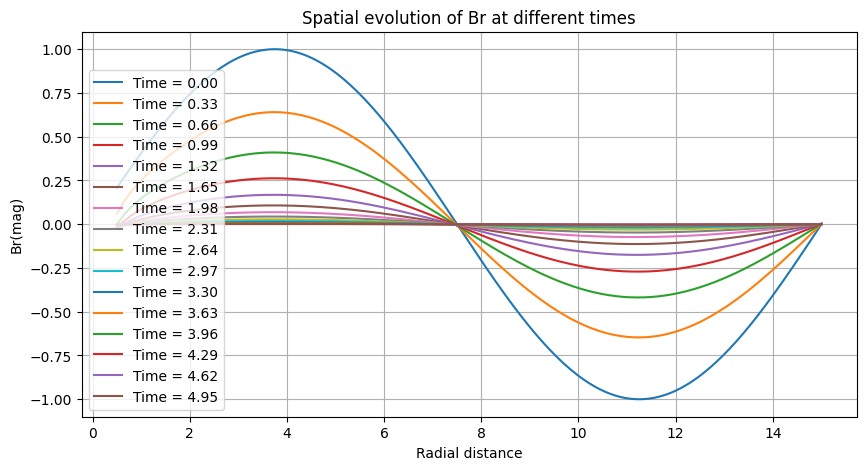

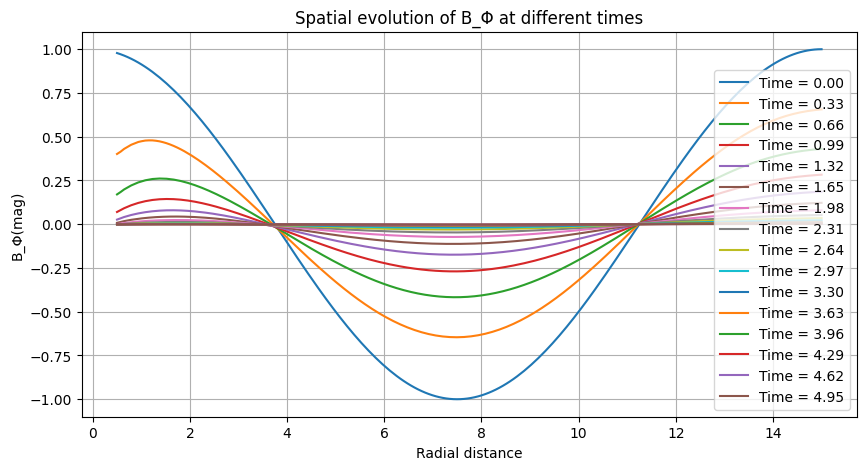

In [18]:
#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, Br_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.ylabel("Br(mag)")
plt.xlabel("Radial distance")
plt.title("Spatial evolution of Br at different times")
plt.legend()
plt.grid()
plt.show()

#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, B_phi_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.ylabel("B_Φ(mag)")
plt.xlabel("Radial distance")
plt.title("Spatial evolution of B_Φ at different times")
plt.legend()
plt.grid()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


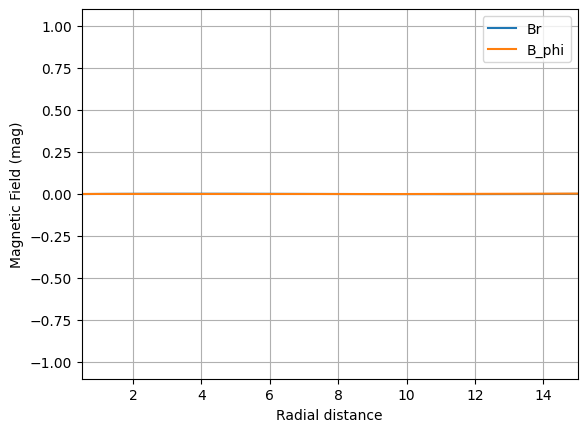

In [20]:
fig, ax = plt.subplots()

# initialize the line
lineBr, = ax.plot(R, Br_evolution[0])
lineBphi, = ax.plot(R, B_phi_evolution[0])

ax.set_xlabel("Radial distance")
ax.set_ylabel("Magnetic Field (mag)")
ax.set_xlim(0.5, R_max)

ax.grid(True)
ax.legend([lineBr, lineBphi], ["Br", "B_phi"], loc='best')

def init():
    # initialize the animation
    ax.set_xlim(0.5, R_max)
    #ax.set_ylim(0, np.max(Br_evolution))
    return lineBr, lineBphi,

def update(frame):
    lineBr.set_data(R, Br_evolution[frame])
    lineBphi.set_data(R, B_phi_evolution[frame])
    return lineBr, lineBphi,

ani = anim.FuncAnimation(fig, update, frames=Nt, interval=100, blit=True, init_func=init)
ani.save('animationSine.gif')
plt.show()

### Using exponential seed field

In [21]:
Br = np.exp(-R/R_max)

B_phi = np.exp(R/R_max)

In [22]:
# EVOLUTION OF Br
# Store the evolution of magnetic field at different radial positions
Br_evolution = np.zeros((Nt + 1, Nr))

#boundary_conditions2(Br_evolution)
# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    Br_evolution[t, :] = np.copy(Br)
    Br = RK4(R,Br)
    
#EVOLUTION OF B_phi
    
# Store the evolution of magnetic field at different radial positions
B_phi_evolution = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    B_phi_evolution[t, :] = np.copy(B_phi)
    B_phi = RK4(R,B_phi)   

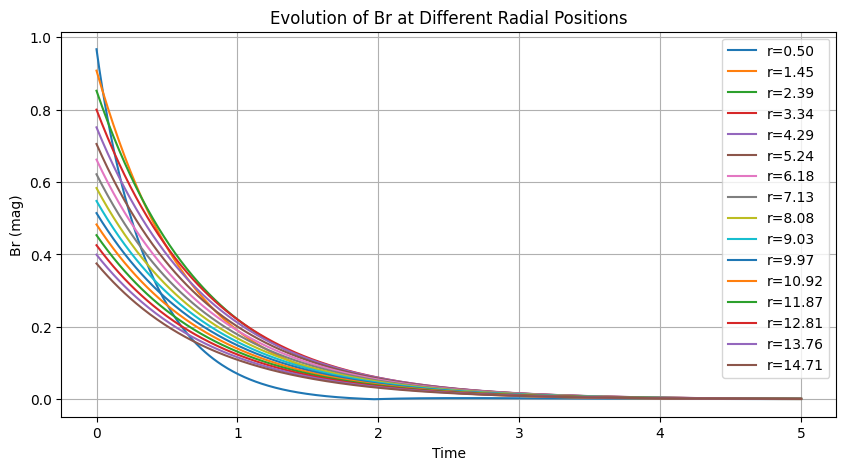

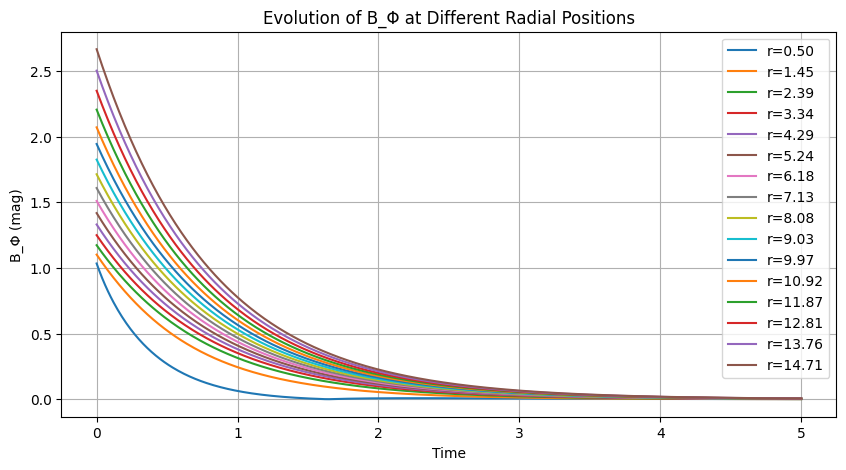

In [23]:
# Plot the evolution of magnetic field at different radial positions over time
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(Br_evolution[:, ::Nr//15]))
plt.xlabel('Time')
plt.ylabel('Br (mag)')
plt.title('Evolution of Br at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(B_phi_evolution[:, ::Nr//15]),label="Evolution curve for B_phi")

plt.xlabel('Time')
plt.ylabel('B_Φ (mag)')
plt.title('Evolution of B_Φ at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

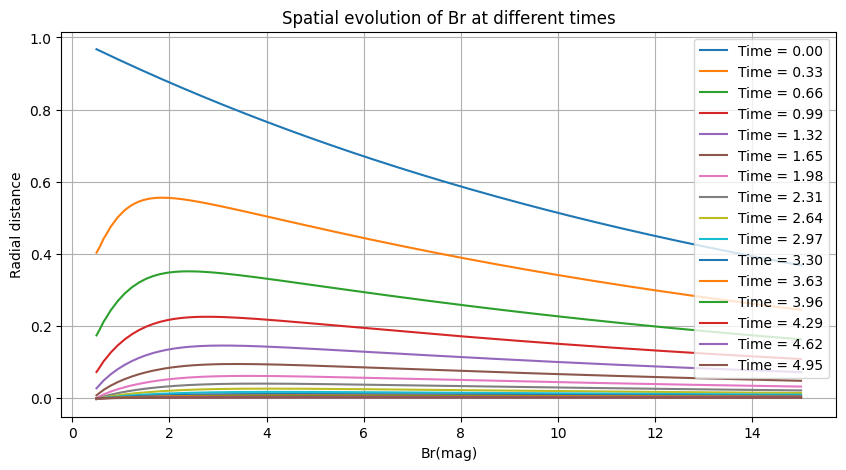

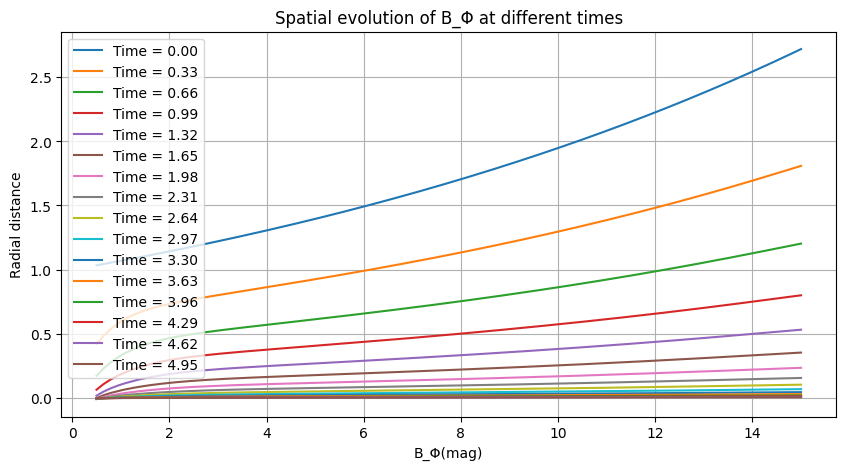

In [24]:
#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, Br_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel("Br(mag)")
plt.ylabel("Radial distance")
plt.title("Spatial evolution of Br at different times")
plt.legend()
plt.grid()
plt.show()

#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, B_phi_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel("B_Φ(mag)")
plt.ylabel("Radial distance")
plt.title("Spatial evolution of B_Φ at different times")
plt.legend()
plt.grid()
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


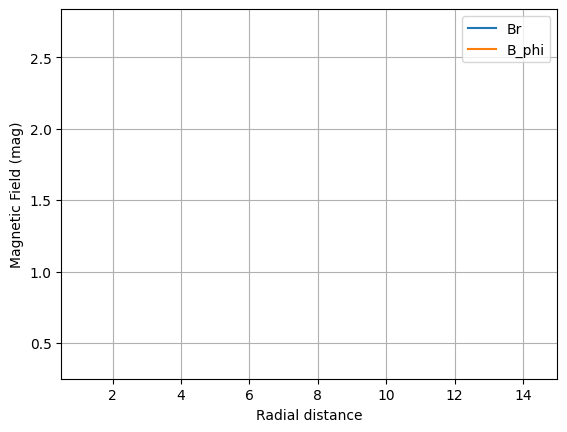

In [25]:
fig, ax = plt.subplots()

# initialize the line
lineBr, = ax.plot(R, Br_evolution[0])
lineBphi, = ax.plot(R, B_phi_evolution[0])

ax.set_xlabel("Radial distance")
ax.set_ylabel("Magnetic Field (mag)")
ax.set_xlim(0.5, R_max)

ax.grid(True)
ax.legend([lineBr, lineBphi], ["Br", "B_phi"], loc='best')

def init():
    # initialize the animation
    ax.set_xlim(0.5, R_max)
    #ax.set_ylim(0, np.max(Br_evolution))
    return lineBr, lineBphi,

def update(frame):
    lineBr.set_data(R, Br_evolution[frame])
    lineBphi.set_data(R, B_phi_evolution[frame])
    return lineBr, lineBphi,

ani = anim.FuncAnimation(fig, update, frames=Nt, interval=100, blit=True, init_func=init)
ani.save('animationExp.gif')
plt.show()

### Using seed field for Harris Sheet magnetic field

In [17]:
Br = np.tanh(R/R_max)

B_phi = np.tanh(-R/R_max)

In [18]:
# EVOLUTION OF Br
# Store the evolution of magnetic field at different radial positions
Br_evolution = np.zeros((Nt + 1, Nr))

#boundary_conditions2(Br_evolution)
# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    Br_evolution[t, :] = np.copy(Br)
    Br = RK4(R,Br)
    
#EVOLUTION OF B_phi
    
# Store the evolution of magnetic field at different radial positions
B_phi_evolution = np.zeros((Nt + 1, Nr))

# Time-stepping scheme using Runge-Kutta
for t in range(Nt + 1):
    B_phi_evolution[t, :] = np.copy(B_phi)
    B_phi = RK4(R,B_phi)  

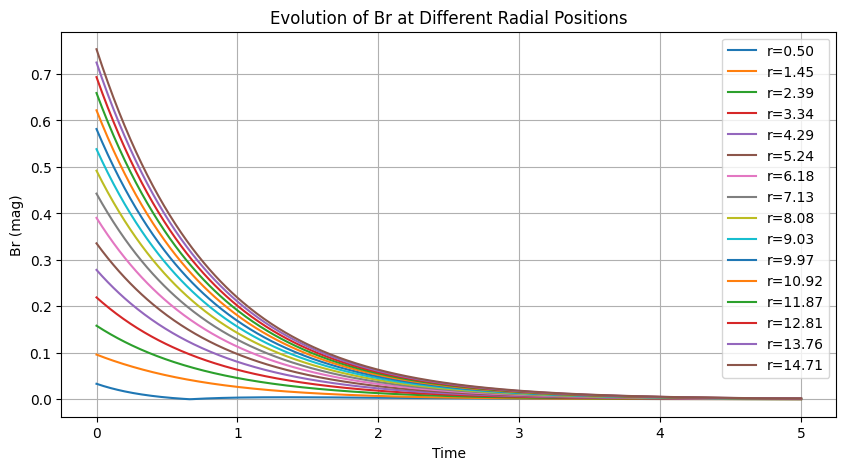

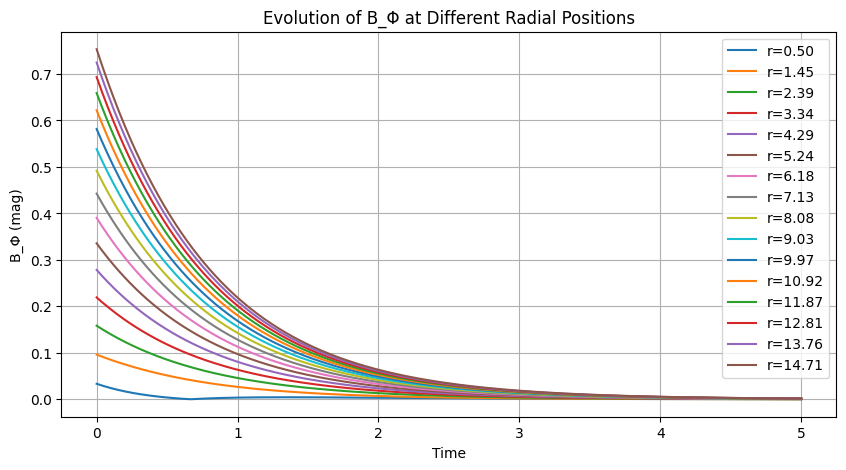

In [19]:
# Plot the evolution of magnetic field at different radial positions over time
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(Br_evolution[:, ::Nr//15]))
plt.xlabel('Time')
plt.ylabel('Br (mag)')
plt.title('Evolution of Br at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, T, Nt + 1),np.abs(B_phi_evolution[:, ::Nr//15]),label="Evolution curve for B_phi")

plt.xlabel('Time')
plt.ylabel('B_Φ (mag)')
plt.title('Evolution of B_Φ at Different Radial Positions')
plt.legend([f'r={R[i]:.2f}' for i in range(0, Nr, Nr//15)])
plt.grid()
plt.show()

In [ ]:
#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, Br_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel("Br(mag)")
plt.ylabel("Radial distance")
plt.title("Spatial evolution of Br at different times")
plt.legend()
plt.grid()
plt.show()

#Spatial evolution at certain times
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 15):  
    plt.plot(R, B_phi_evolution[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel("B_Φ(mag)")
plt.ylabel("Radial distance")
plt.title("Spatial evolution of B_Φ at different times")
plt.legend()
plt.grid()
plt.show()

At first, different eigenmodes compete, but the one with the largest exponential growth rate will win out and eventually come to dominate. Thus, we do not expect the solution in the kinematic regime to be sensitive to the seed field, which is evident.

## Finding pitch angle 

In magnetohydrodynamics (MHD), the pitch angle is a crucial parameter that describes the orientation of magnetic field lines with respect to the direction of plasma motion.
Here, we will explore the evolution of the pitch angle p of the mean magnetic field, which is given by-

$$tan p = \frac{B_r}{B_\phi}$$

In [13]:
def angle(Br,B_phi):
    return np.arctan(Br/B_phi)

In [18]:
pitch = np.zeros((Nt + 1, Nr))

for t in range(Nt + 1):
    pitch[t, :] = angle(Br_evolution[t, :], B_phi_evolution[t, :])
pitch = -1* pitch

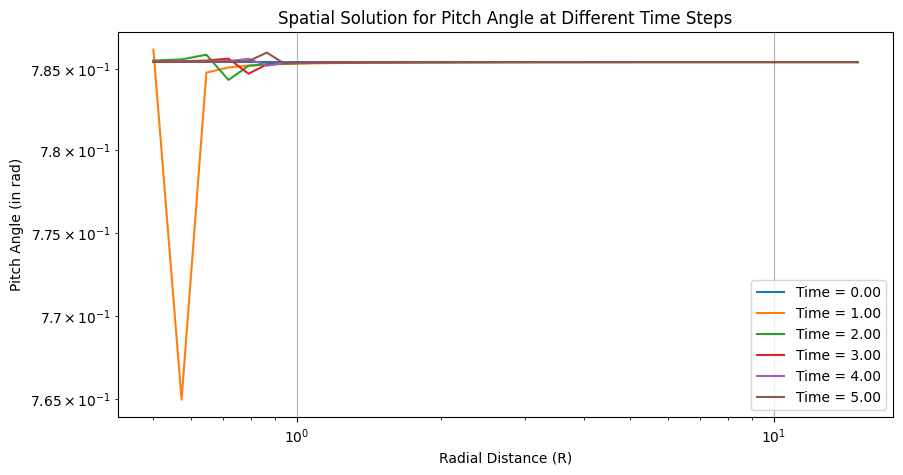

In [21]:
# Plot the spatial solution for the pitch angle
plt.figure(figsize=(10, 5))
for t in range(0, Nt + 1, Nt // 5):  # Plot every 15th time step
    plt.plot(R, pitch[t, :], label=f'Time = {t * dt:.2f}')
plt.xlabel('Radial Distance (R)')
plt.ylabel('Pitch Angle (in rad)')
plt.title('Spatial Solution for Pitch Angle at Different Time Steps')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

## Overplotting exact solution for modified bessel function of 2nd kind 

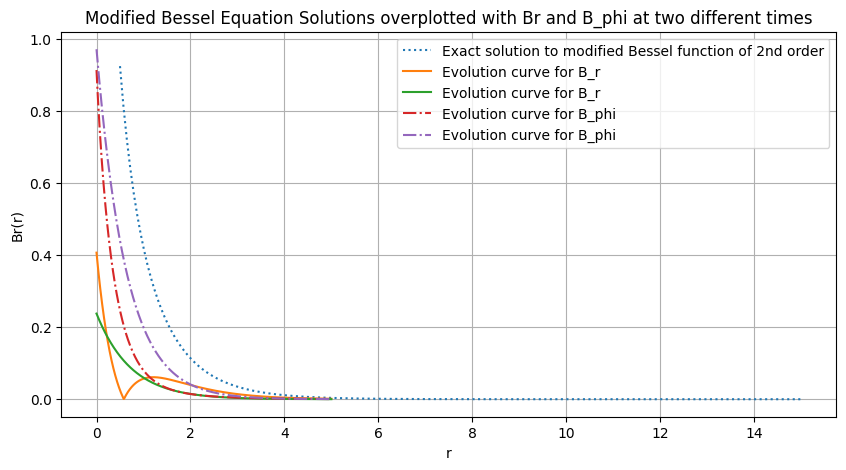

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv

# Define the parameters
R_max = 15
Nr = 200
dr = R_max / Nr

# Create the R array
R = np.linspace(0.5, R_max, Nr)

# Compute the solution
Br_values = kv(0, R)

# Plot the solution
plt.figure(figsize=(10, 5))
plt.plot(R, Br_values, label='Exact solution to modified Bessel function of 2nd order', linestyle = 'dotted')
plt.plot(np.linspace(0, T, Nt + 1),np.abs(Br_evolution[:, ::Nr//2]),label="Evolution curve for B_r")
plt.plot(np.linspace(0, T, Nt + 1),np.abs(B_phi_evolution[:, ::Nr//2]),label="Evolution curve for B_phi",linestyle ='dashdot')
plt.xlabel('r')
plt.ylabel('Br(r)')
plt.title('Modified Bessel Equation Solutions overplotted with Br and B_phi at two different times')
plt.legend()
plt.grid()
plt.show()